# Tutorial 5 : U-GNP Mini Summary [WIP]

Last Update : 22 June 2019

**Aim**: 


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from ntbks_helpers import get_gp_datasets # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less
datasets = get_gp_datasets(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model


In [5]:
from neuralproc import GlobalNeuralProcess, discard_ith_arg
from neuralproc.utils.helpers import change_param
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.05, max_n_indcs=.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.05, max_n_indcs=.5),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

gnp_kwargs = dict(is_summary=True,
                  r_dim=32, 
                  get_cntxt_trgt=get_cntxt_trgt,
                  TmpSelfAttn=change_param(UnetCNN,
                                          Conv=torch.nn.Conv1d,
                                           Pool=torch.nn.MaxPool1d,
                                           upsample_mode="linear",
                                          n_layers=10,
                                           is_bottleneck=True,
                                          is_depth_separable=True,
                                          Normalization=torch.nn.BatchNorm1d,
                                          is_chan_last=True,
                                           is_double_conv=True,
                                          kernel_size=7,
                                          _is_summary=True),
                 #XEncoder=torch.nn.Linear,
                 #XYEncoder=discard_ith_arg(MLP, i=0),
                 #is_use_x=True,
                 #x_transf_dim=None,
                  #keys_to_tmp_attn="weighted_dist",
                 #tmp_to_queries_attn="weighted_dist"
                 )

"""
gnp_kwargs = dict(is_summary=True,
                  r_dim=32, 
                  get_cntxt_trgt=get_cntxt_trgt,
                  TmpSelfAttn=SelfAttention)
"""

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [6]:
from utils.helpers import count_parameters

In [7]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 21800


Using `"transformer"` attention increases the number of parameters, but using a deterministic path as well a smaller representation seize decreases the number of parameters.

## Training

In [8]:
from ntbks_helpers import train_all_models_

train_all_models_(data_models, "results/notebooks/neural_process/u_gnp_summary_mini",
                  is_retrain=True) # if false load precomputed


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1        0.7687     +  65.0592


      2        0.1343     +  98.0080


      3       -0.0986     +  171.8214


      4       -0.2803     +  162.5613


      5       -0.4436     +  173.5420


      6       -0.4741     +  167.7907


      7       -0.5585     +  172.8362


      8       -0.5452        167.2542


      9       -0.5994     +  163.4201


     10       -0.6223     +  152.4797


     11       -0.5946        166.0646


     12       -0.6410     +  161.8531


     13       -0.7189     +  164.8359


     14       -0.6752        166.0219


     15       -0.7391     +  158.3310


     16       -0.7070        161.7632


     17       -0.7276        172.4069


     18       -0.6815        171.5723


     19       -0.7275        165.8141


     20       -0.7442     +  157.8213


     21       -0.7740     +  166.2438


     22       -0.7646        169.0357


     23       -0.7390        164.5624


     24       -0.7772     +  162.2179


     25       -0.7719        160.9838


     26       -0.8088     +  168.4291


     27       -0.7780        144.7610


     28       -0.7884        167.5592


     29       -0.7932        168.8489


     30       -0.7746        172.7467


     31       -0.7940        172.7099


     32       -0.7934        169.3562


     33       -0.8164     +  167.5299


     34       -0.8423     +  170.3875


     35       -0.8032        168.8902


     36       -0.8045        164.5843


     37       -0.8276        173.0513


     38       -0.8480     +  156.4307


     39       -0.8222        162.8227


     40       -0.8481     +  154.2462


     41       -0.8185        165.1554


     42       -0.7748        169.6985


     43       -0.8328        166.5928


     44       -0.8768     +  162.5061


     45       -0.8274        161.6523


     46       -0.8264        154.5868


     47       -0.8389        168.3686


     48       -0.9042     +  174.3064


     49       -0.8532        165.3467


     50       -0.8593        172.5874
Re-initializing optimizer.

--- Training periodic ---



  epoch    train_loss    cp       dur
-------  ------------  ----  --------
      1        1.3575     +  167.0238


      2        1.3265     +  148.8718


      3        1.3190     +  169.3519


      4        1.3025     +  159.9185


      5        1.2844     +  155.3557


      6        1.2745     +  163.9422


      7        1.1541     +  149.9335


      8        0.9611     +  155.7563


      9        0.8158     +  154.7243


     10        0.7630     +  172.0831


     11        0.7281     +  168.9798


     12        0.6797     +  165.6243


     13        0.7038        164.3380


     14        0.6609     +  167.2297


     15        0.5989     +  165.6853


     16        0.6924        167.4121


     17        0.5670     +  162.5923


     18        0.6294        170.7946


     19        0.5353     +  155.6911


     20        0.6087        170.9778


     21        0.5082     +  170.2704


     22        0.5309        166.0503


     23        0.4736     +  168.7018


     24        0.4766        168.3573


     25        0.5032        169.0130


     26        0.4231     +  172.4859


     27        0.4378        164.0157


     28        0.5130        169.9881


     29        0.4161     +  168.7987


     30        0.3992     +  159.5423


     31        0.3494     +  163.4097


     32        0.4705        162.0725


     33        0.4312        167.8046


     34        0.4274        169.5351


     35        0.4019        158.3260


     36        0.3536        163.0503


     37        0.3970        170.6066


     38        0.4155        156.7996


     39        0.3196     +  152.5910


     40        0.3379        159.2322


     41        0.3343        126.4854


     42        0.3053     +  117.1567


     43        0.3787        117.2108


     44        0.3176        109.5442


     45        0.3327        242.1310


     46        0.2920     +  232.5263


     47        0.2980        244.0110


     48        0.2778     +  236.7612


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  epoch    train_loss    cp       dur
-------  ------------  ----  --------
      1        0.9058     +  243.8178


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      4       -0.0582     +  244.1124


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      7       -0.1734     +  246.8546


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     10       -0.2654     +  248.2812


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     13       -0.3517     +  243.7208


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     16       -0.3697     +  241.9648


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     19       -0.4035     +  237.0927


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     24       -0.3943        242.7598


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     29       -0.4436     +  244.1116


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     32       -0.4464        244.6165


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     33       -0.4480        242.7370


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     35       -0.4858     +  243.2132


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     36       -0.4630        237.3367


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     38       -0.4772        242.8578


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     39       -0.4346        238.0316


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     42       -0.5357     +  237.1225


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     45       -0.4582        245.5411


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     46       -0.4387        239.5406


     47       -0.4830        242.4713


     48       -0.4779        241.8148


     49       -0.5179        242.1060


     50       -0.5002        241.9424
Re-initializing optimizer.

--- Training noisy-matern ---



  epoch    train_loss    cp       dur
-------  ------------  ----  --------
      1        1.0689     +  239.6627


      2        0.7514     +  240.1267


      3        0.6720     +  241.9960


      4        0.6276     +  233.7372


      5        0.5796     +  240.1487


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



      9        0.5240     +  134.9305


     10        0.5111     +  243.7482


     11        0.4972     +  185.8164


     12        0.4892     +  113.5061


     13        0.4779     +  116.7199


     14        0.4788        116.7372


     15        0.4504     +  114.9832


     16        0.4501     +  114.8069


     17        0.4082     +  203.4579


     18        0.3982     +  124.3587


     19        0.3810     +  146.1459


     20        0.3349     +  119.8828


     21        0.3246     +  150.4226


     22        0.2819     +  137.9773


     23        0.2472     +  131.7002


     24        0.2307     +  142.1040


     25        0.2600        250.1804


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     28        0.2018     +  252.0902


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     31        0.1786     +  255.5408


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     34        0.1673        250.3947


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     37        0.1791        249.9423


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     40        0.1442     +  251.8518


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     44        0.1173        251.4674


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     47        0.1014        252.9309


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     50        0.1183        253.9696
Re-initializing optimizer.


The model converges extremely quickly ($\sim 15$ epochs)  but already has very good predictions after $\sim 5$ epochs.

# Inference


In [19]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.0697008067369465
std: 0.3034900905191897
std: 0.6617203012108803
std: 0.7336964082717896


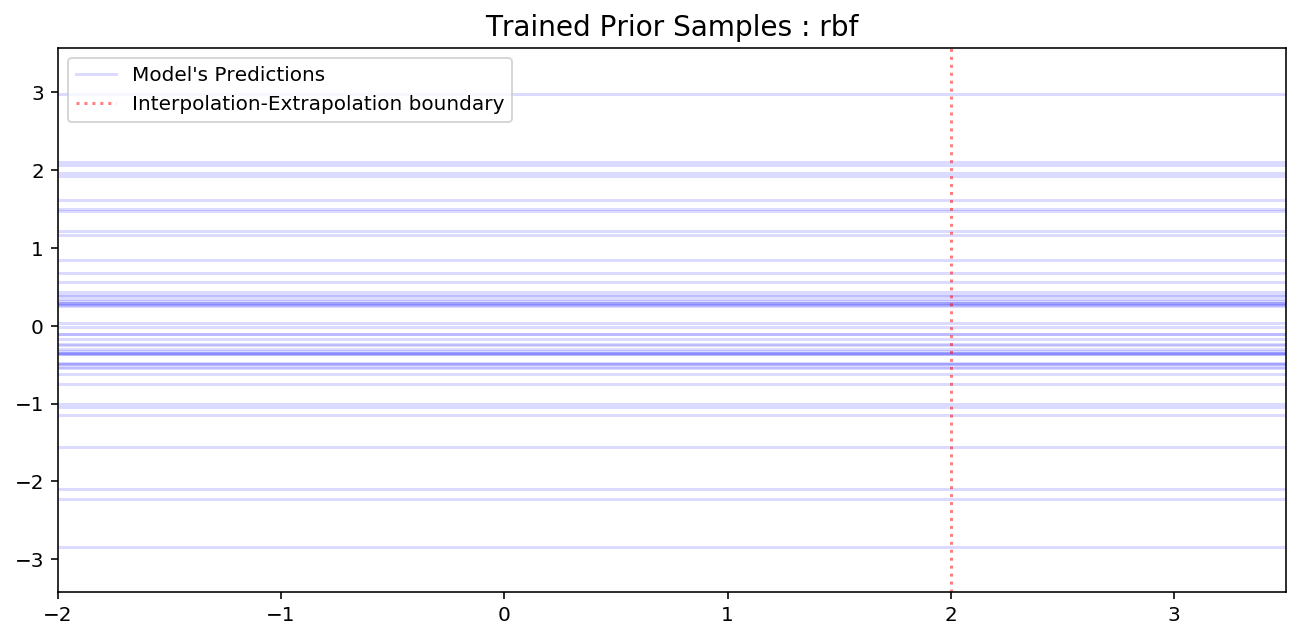

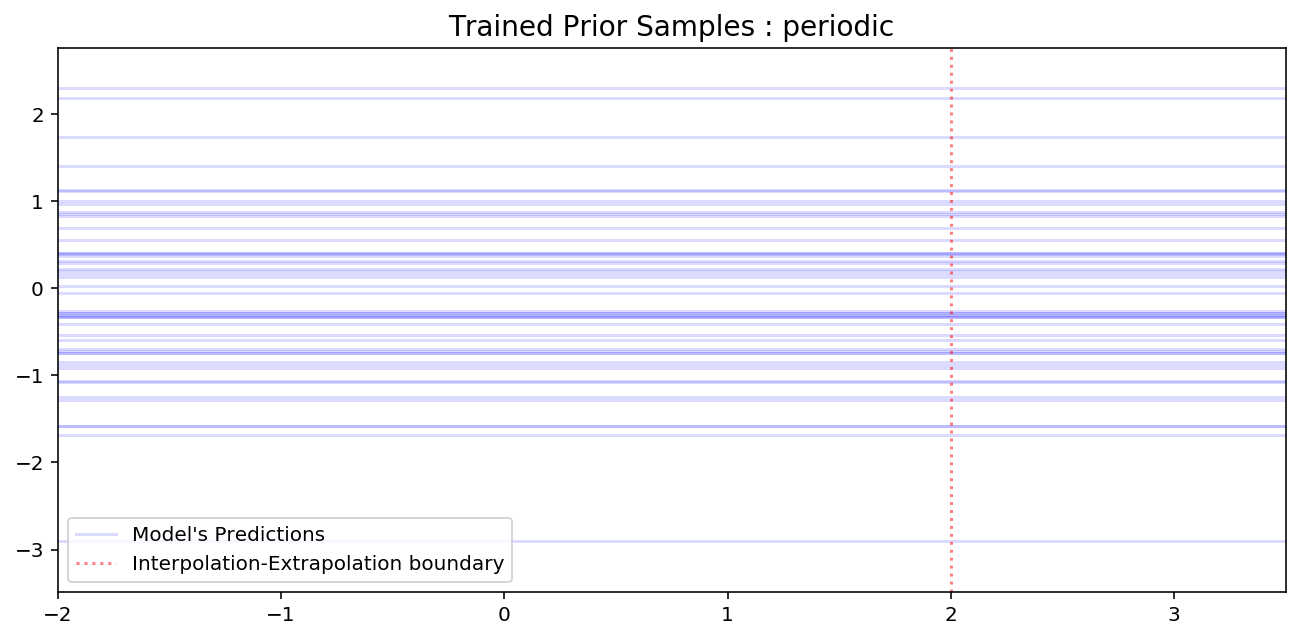

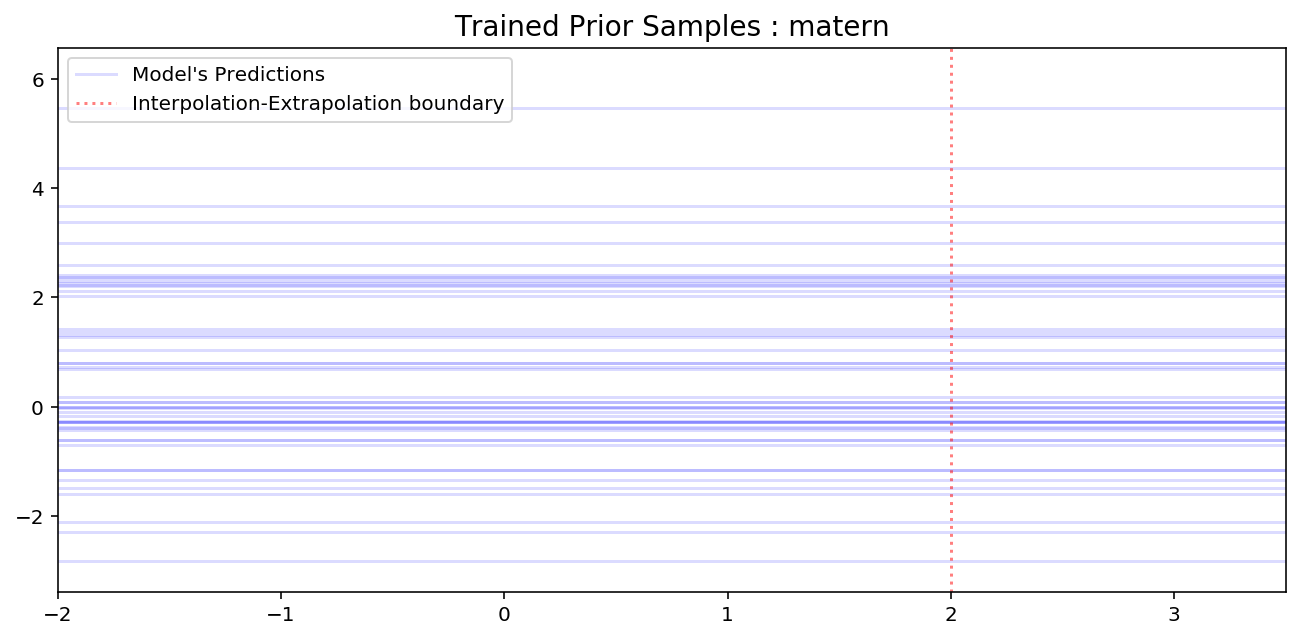

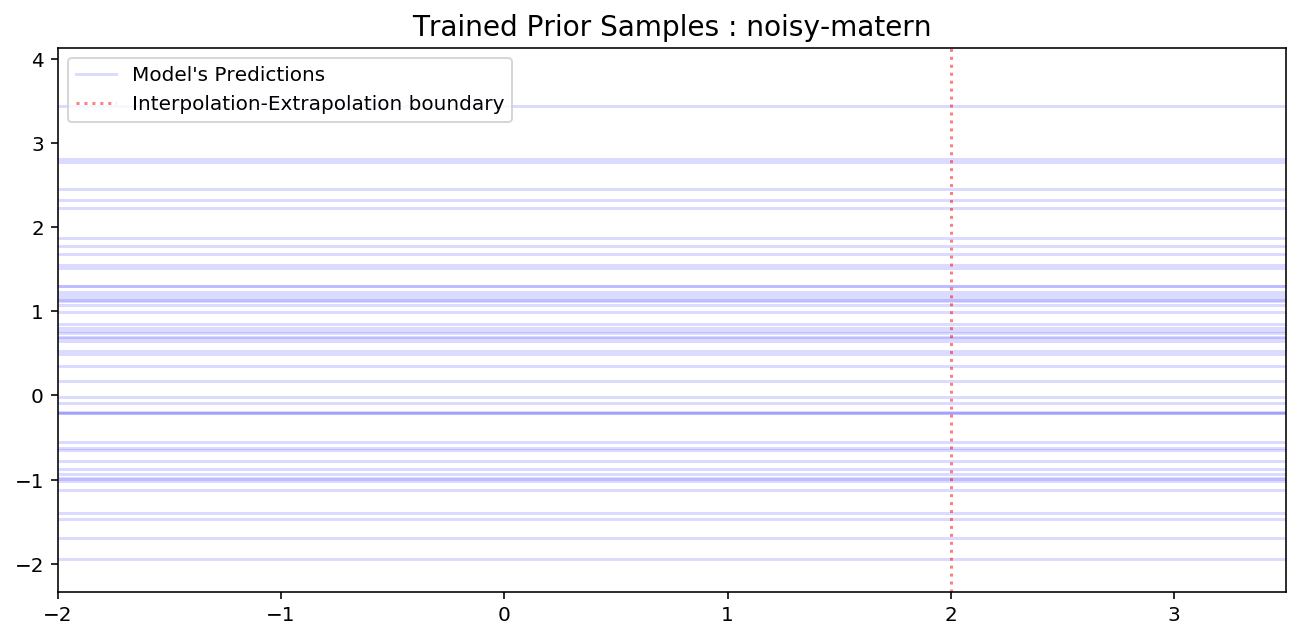

In [20]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

In [21]:
for k,(neural_proc, dataset) in data_models.items():
    break

In [22]:
torch.nn.functional.softplus(neural_proc.keys_to_tmp_attender.radial_basis_func.length_scale)

tensor([0.0114], grad_fn=<SoftplusBackward>)

In [23]:
from neuralproc.utils.helpers import rescale_range

for k,(neural_proc, dataset) in data_models.items():
    extrap_rescaled_range = tuple(rescale_range(np.array(EXTRAPOLATION_RANGE), (-2,2), (-1,1)))
    neural_proc.extend_tmp_queries(extrap_rescaled_range)

std: 0.24844509363174438
std: 0.6590712070465088
std: 0.4029252529144287
std: 0.46972382068634033


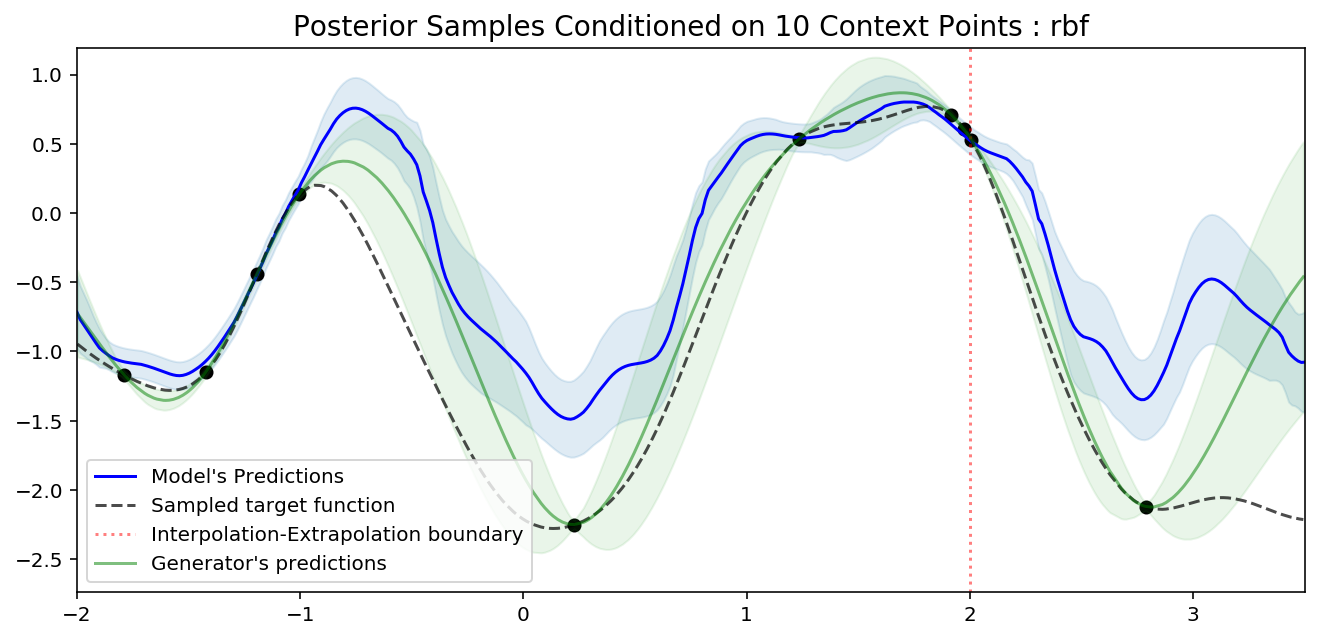

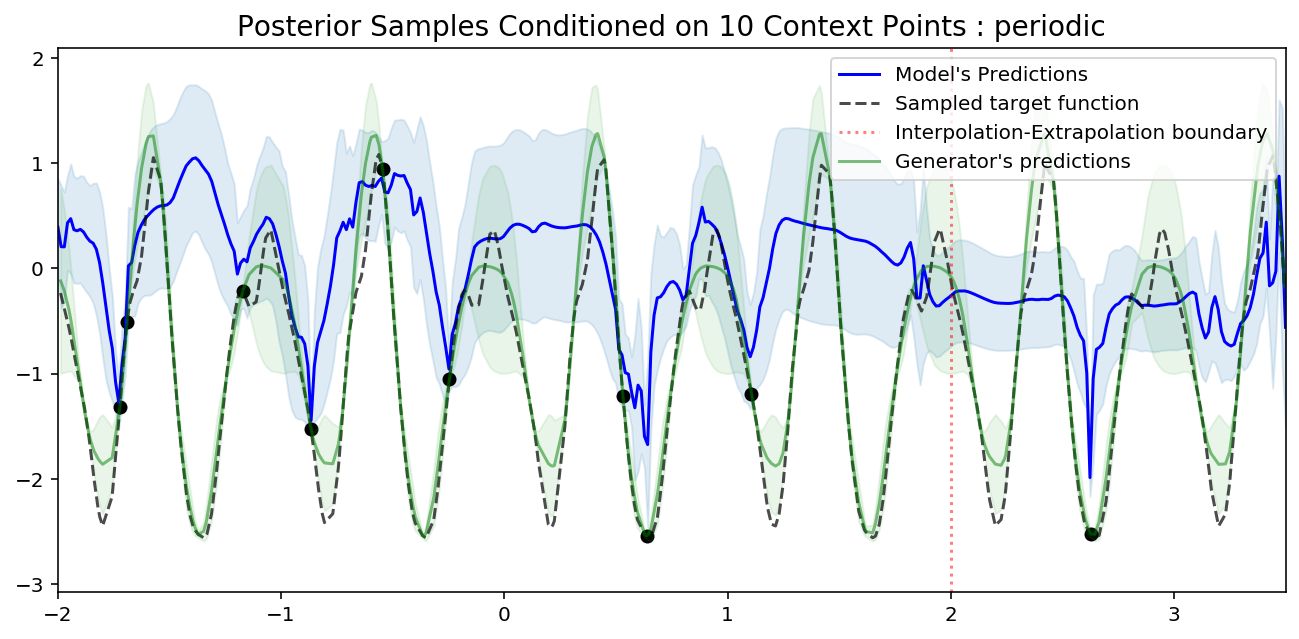

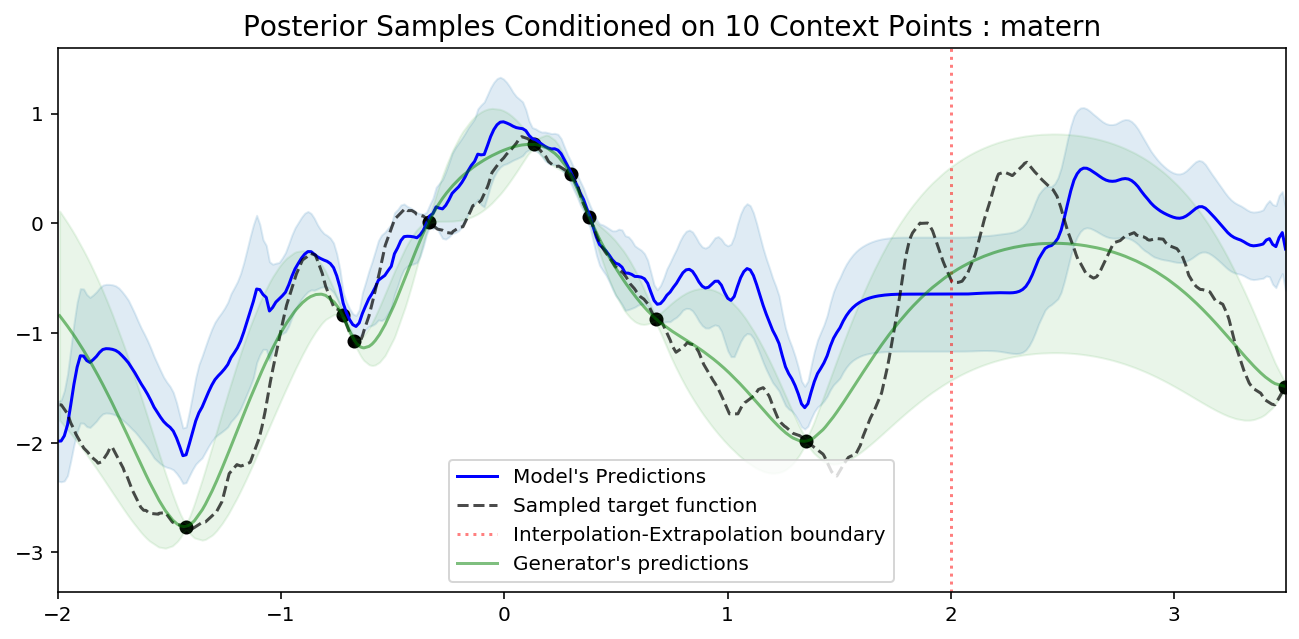

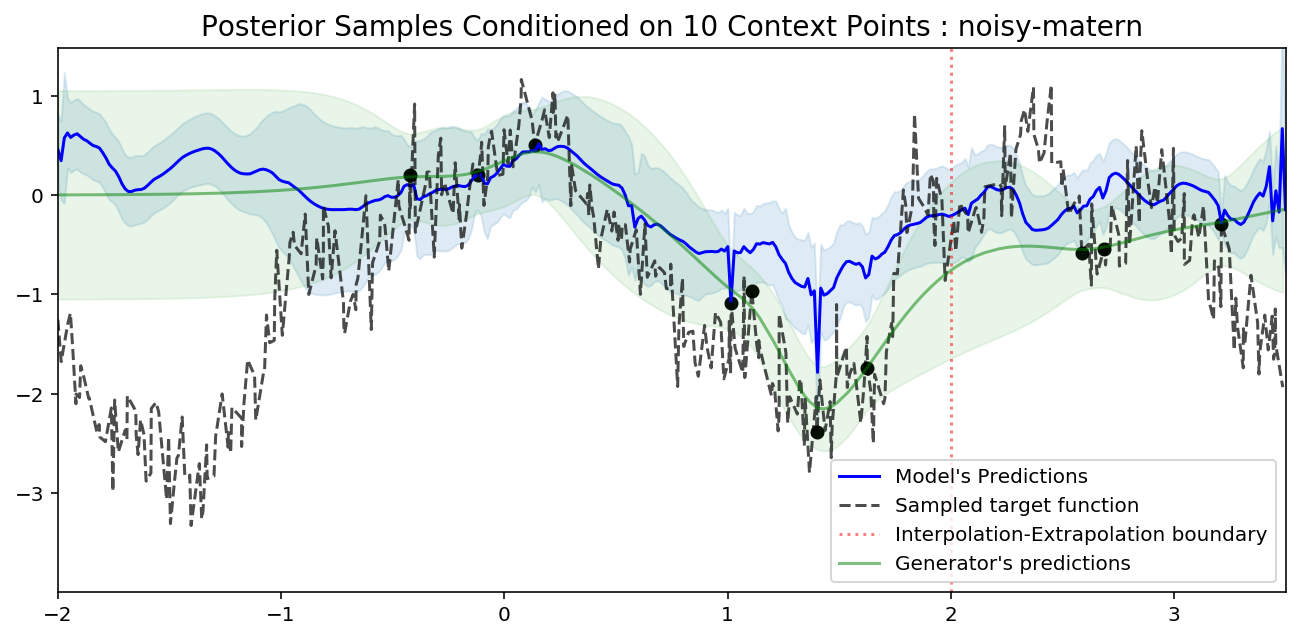

In [24]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.36258190870285034
std: 0.7962364554405212
std: 0.4868764281272888
std: 0.48574140667915344


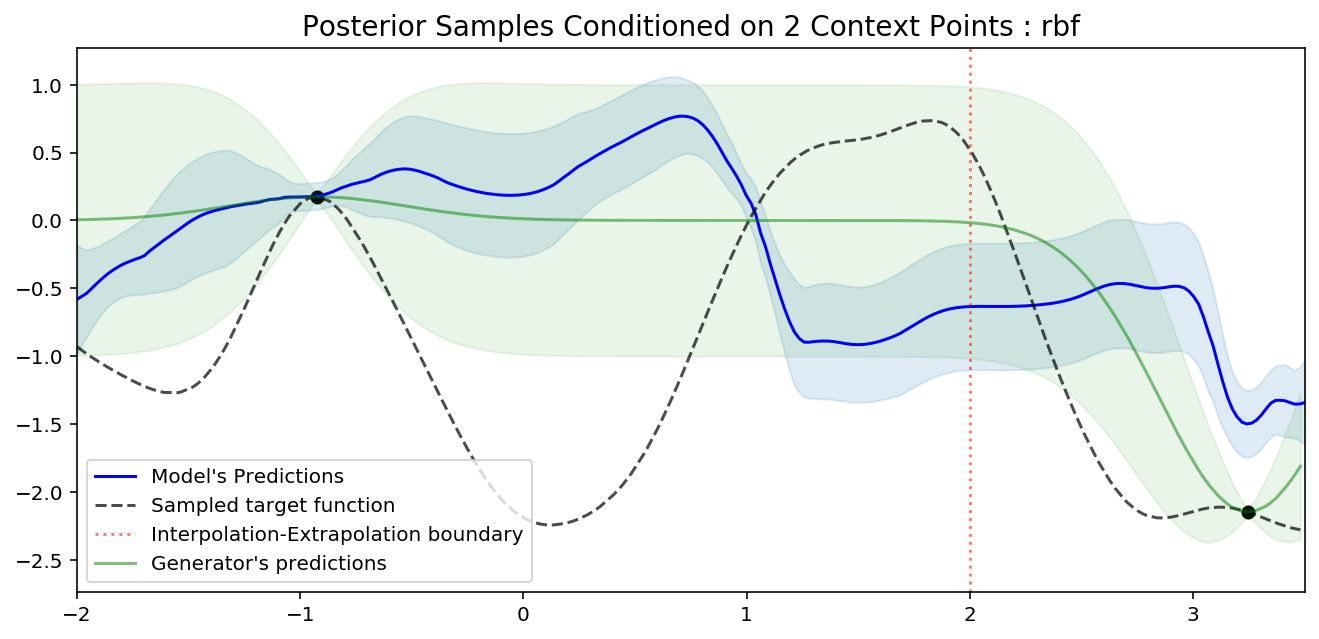

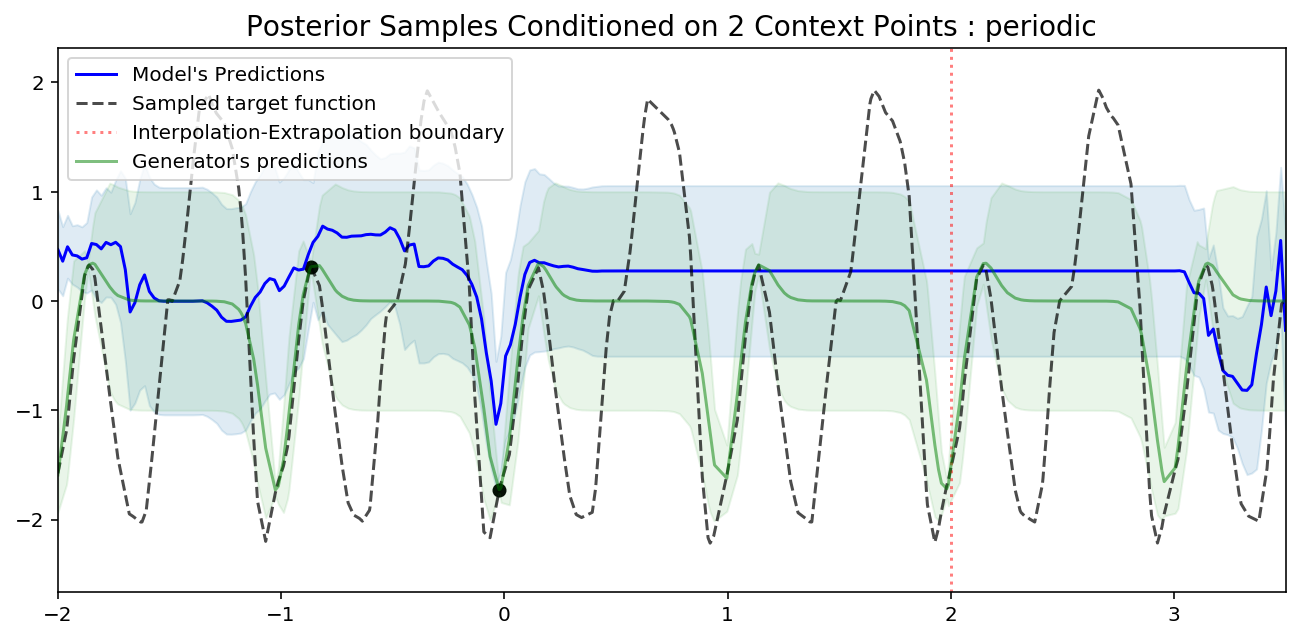

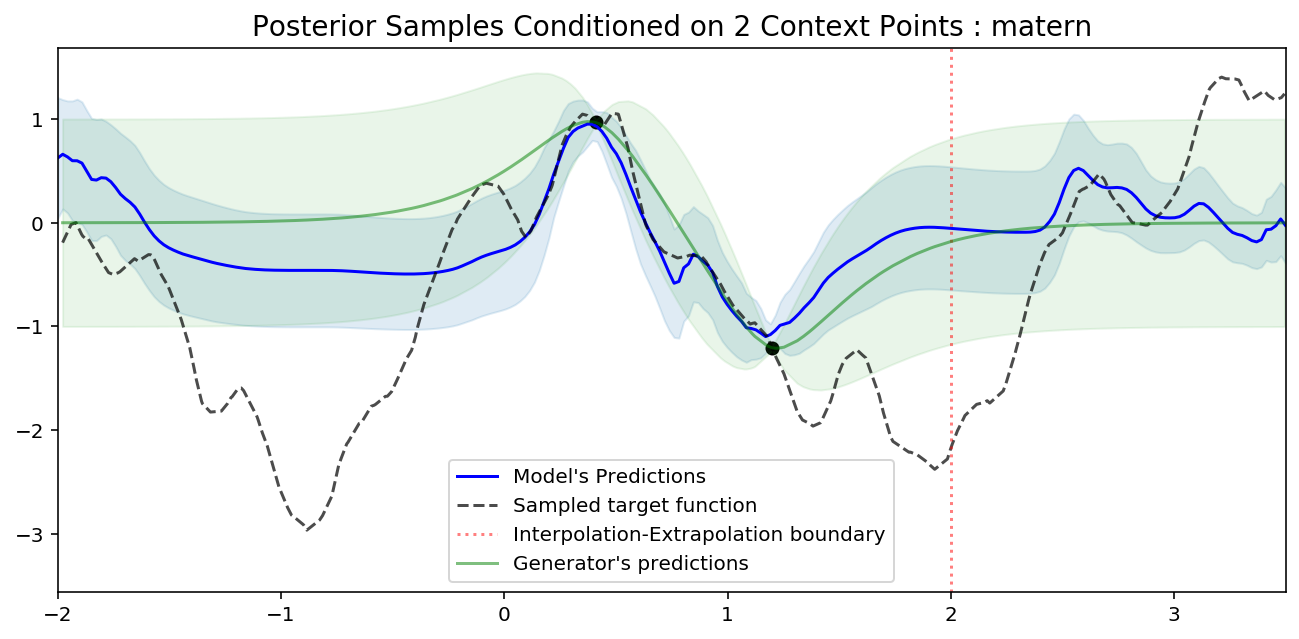

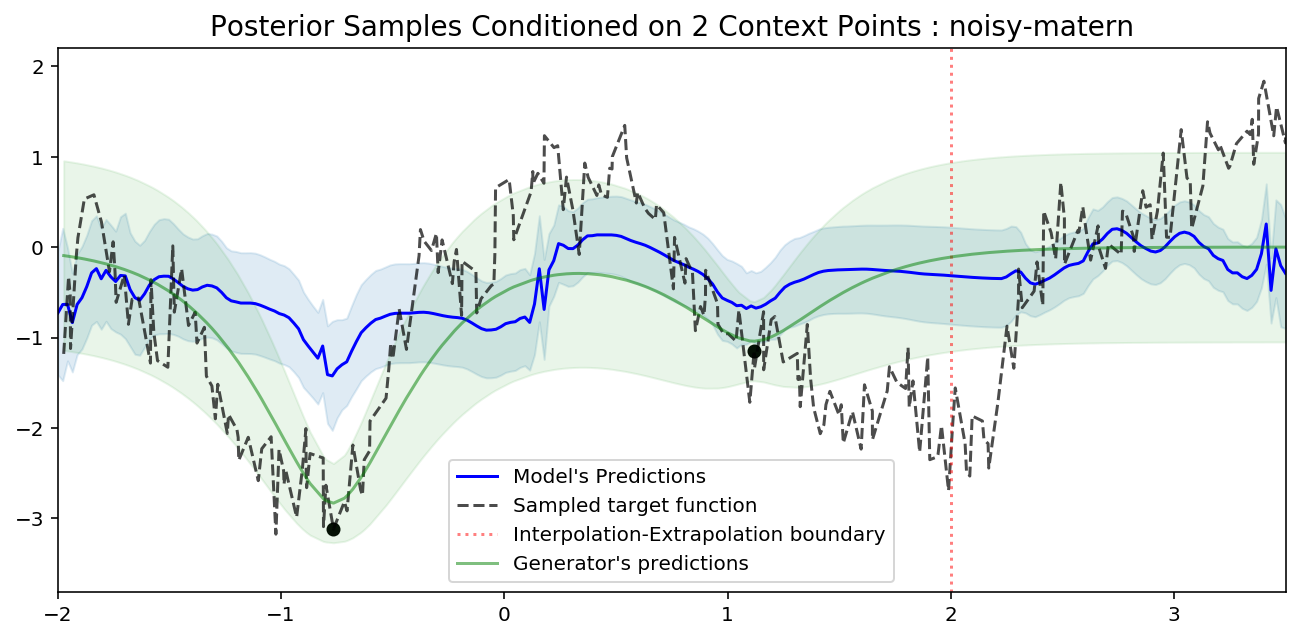

In [25]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.17240527272224426
std: 0.6001760959625244
std: 0.2685695290565491
std: 0.44139331579208374


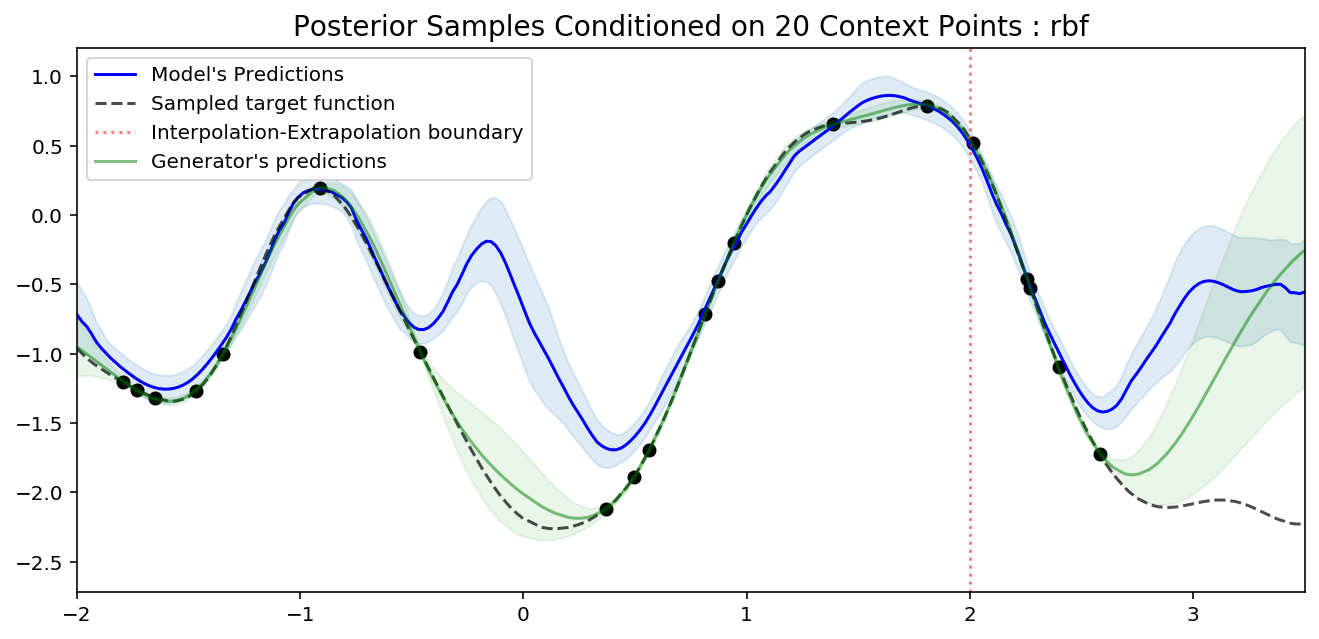

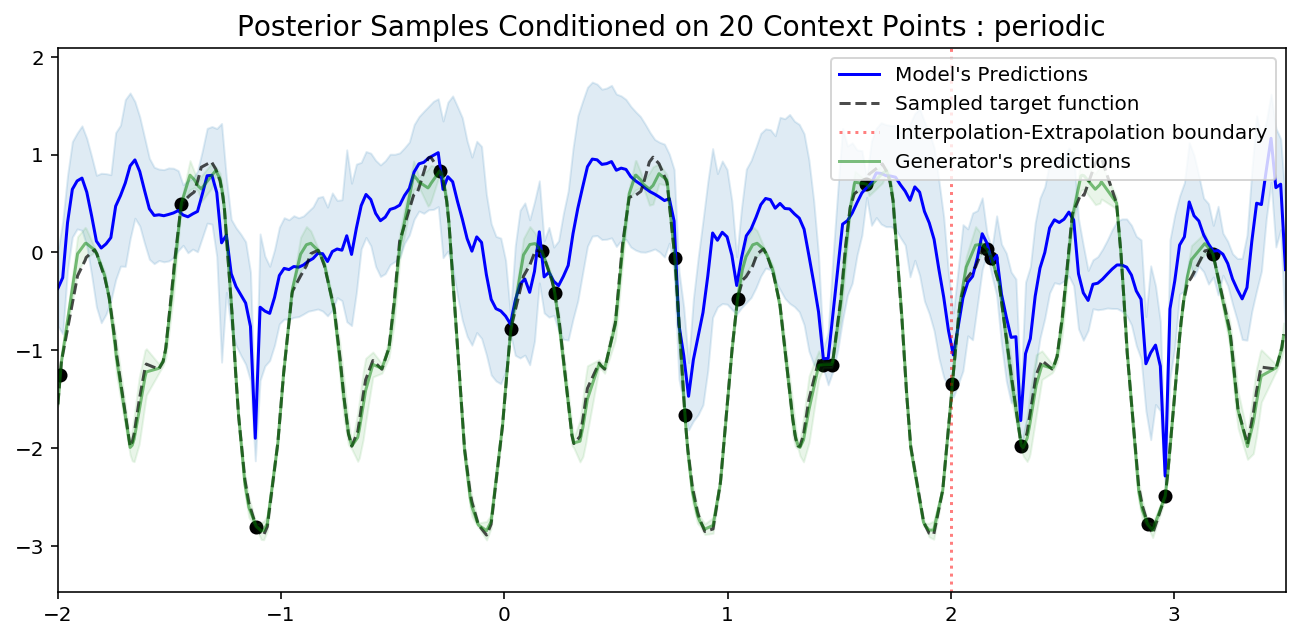

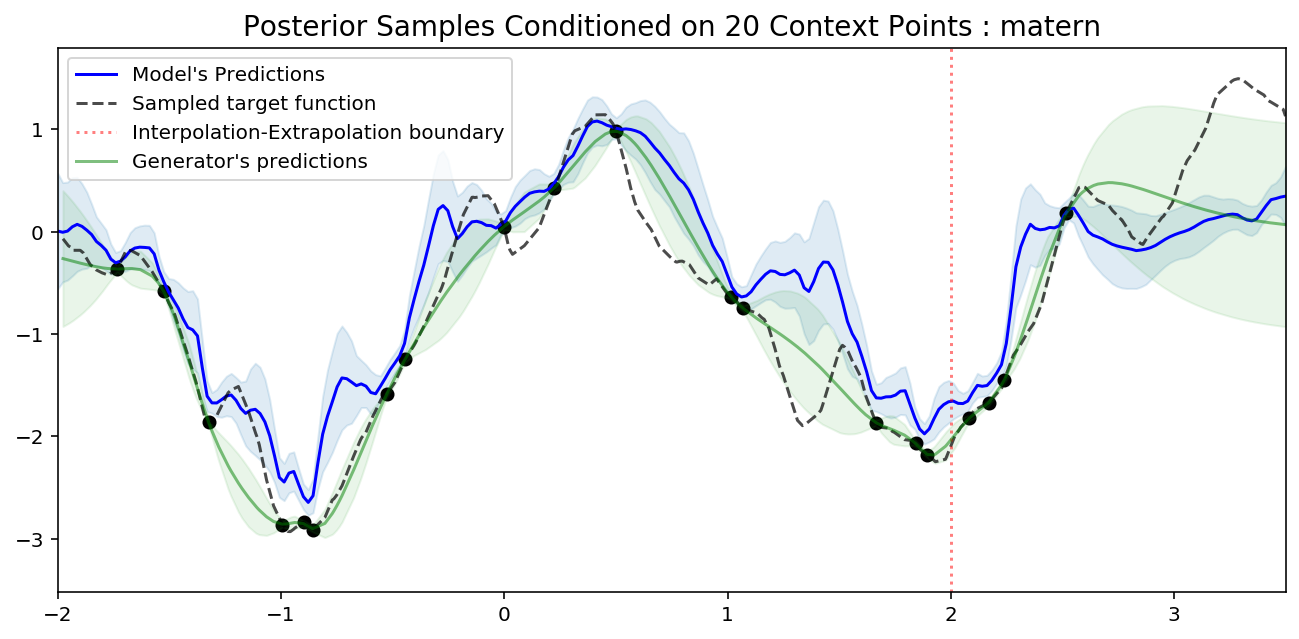

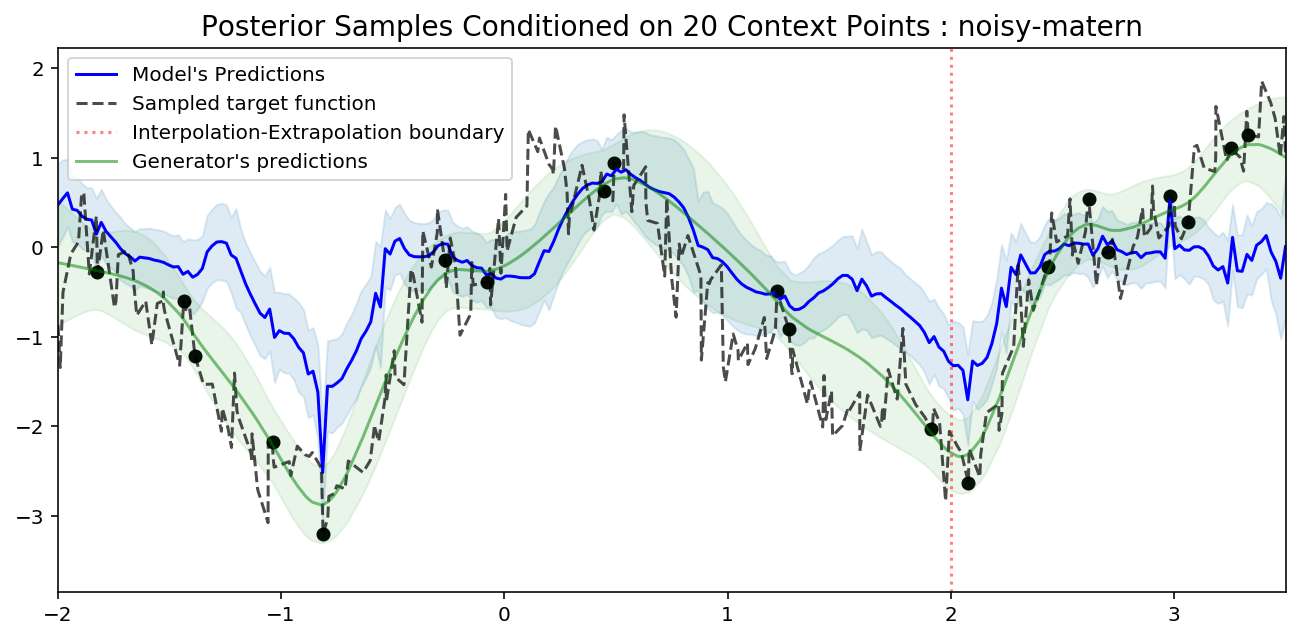

In [26]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

std: 0.45675572752952576
std: 0.8278635144233704
std: 0.5018253922462463
std: 0.4900353252887726


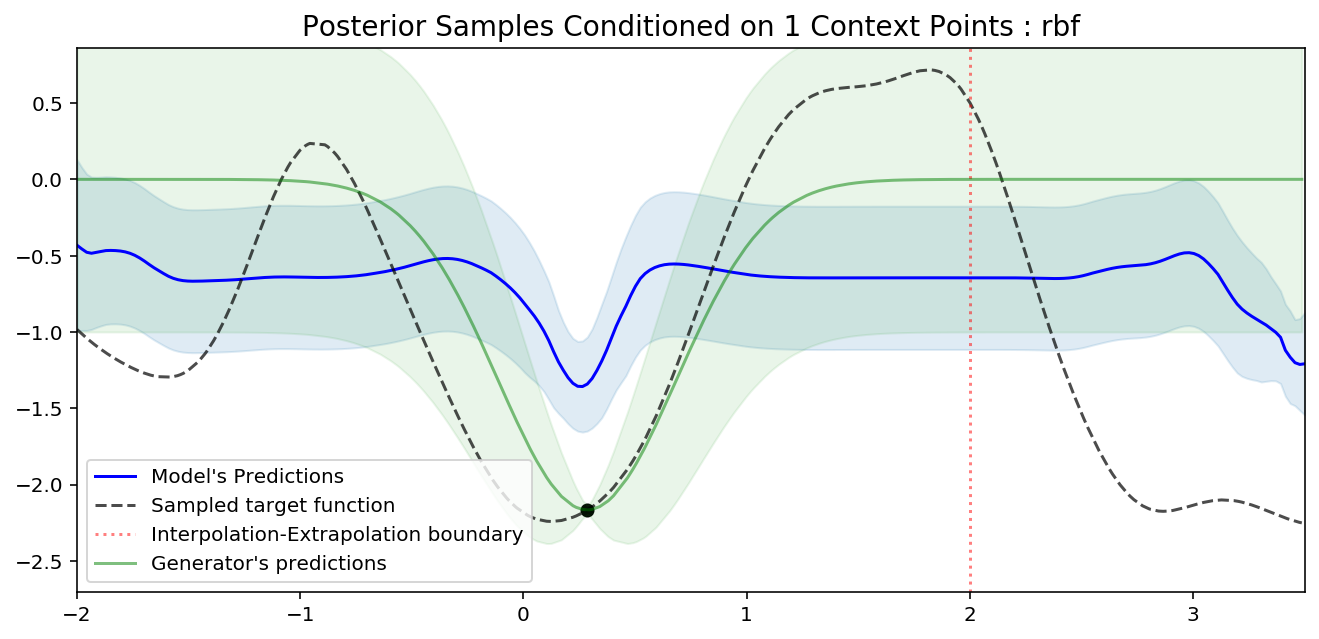

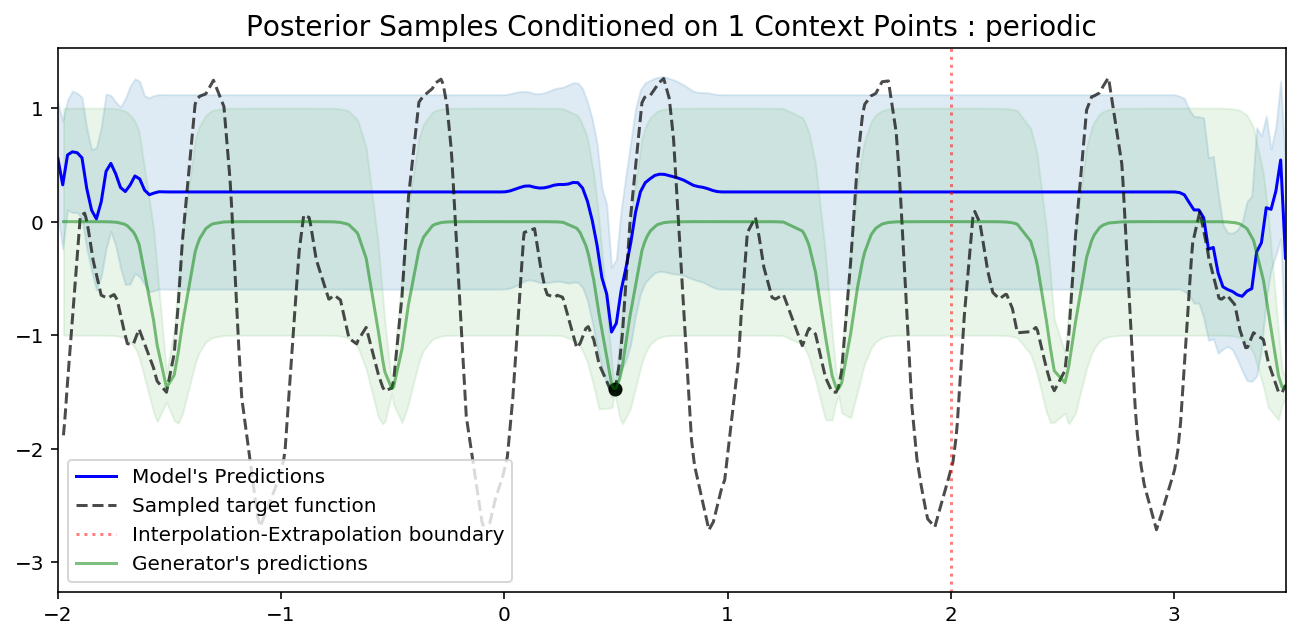

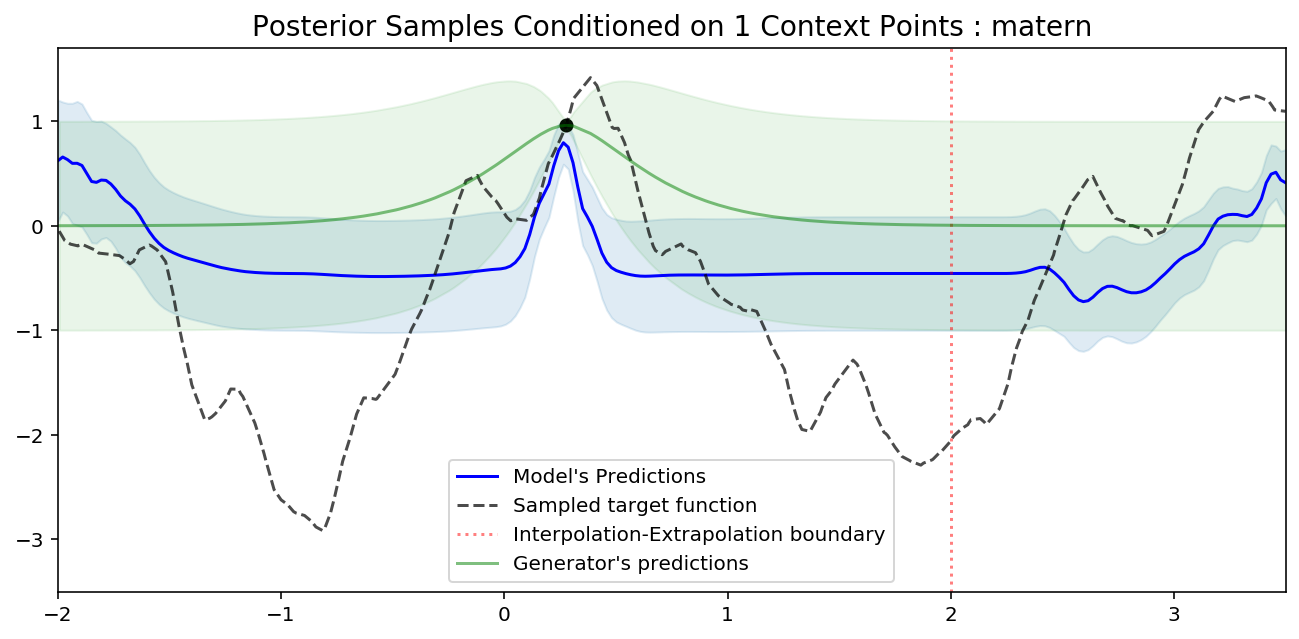

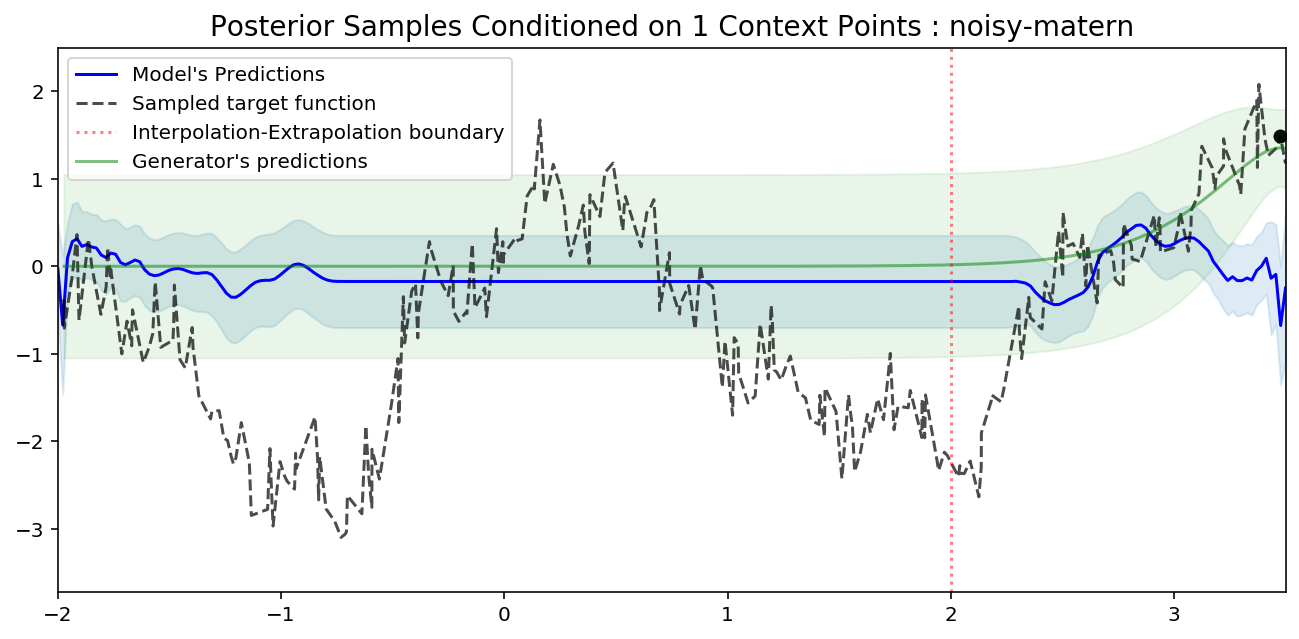

In [27]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- often close to GP with the correct kernel
- the uncertainty decreases close to context points
- no more underfitting : the sampled function all go through or close to the context points
- does all of this with "only" 50k param (and I did not try to go below).
- very good results after $\sim 5$ epochs

**Bad**:
- there seems be some strange "jumps" in regions far from points. This is probably due to the softmax in cross attention, indicating that a head attends to a new point. This makes the model less smooth than GP, but could probably be solved using self attention or a larger model. 
- cannot extrapolate
- still not as smooth as GP
- not good at periodicity

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb